In [201]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score, cross_validate
from sklearn.svm import SVR
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error, mean_absolute_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization, Activation
from tensorflow.keras.models import Sequential



In [ ]:
df = pd.read_excel('/content/drive/MyDrive/DatasetsVKR/df_norm.xlsx').drop(['Unnamed: 0'], axis = 1)
print(df.shape)
df.info()

(922, 13)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 922 entries, 0 to 921
Data columns (total 13 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Соотношение матрица-наполнитель       922 non-null    float64
 1   Плотность, кг/м3                      922 non-null    float64
 2   Модуль упругости, ГПа                 922 non-null    float64
 3   Количество отвердителя, м.%           922 non-null    float64
 4   Содержание эпоксидных групп,%_2       922 non-null    float64
 5   Температура вспышки, С_2              922 non-null    float64
 6   Поверхностная плотность, г/м2         922 non-null    float64
 7   Модуль упругости при растяжении, ГПа  922 non-null    float64
 8   Прочность при растяжении, МПа         922 non-null    float64
 9   Потребление смолы, г/м2               922 non-null    float64
 10  Угол нашивки                          922 non-null    int64  
 11  Шаг нашив

In [ ]:
# в соответствии с заданием ВКР необходимо обучить модели для прогноза параметров модуля упругости при растяжении и прочности при растяжении
df

,Соотношение матрица-наполнитель,"Плотность, кг/м3","Модуль упругости, ГПа","Количество отвердителя, м.%","Содержание эпоксидных групп,%_2","Температура вспышки, С_2","Поверхностная плотность, г/м2","Модуль упругости при растяжении, ГПа","Прочность при растяжении, МПа","Потребление смолы, г/м2",Угол нашивки,Шаг нашивки,Плотность нашивки
0,1.857143,2030.000000,738.736842,50.000000,23.750000,284.615385,210.000000,70.000000,3000.000000,220.000000,0,4.000000,60.000000
1,1.857143,2030.000000,738.736842,129.000000,21.250000,300.000000,210.000000,70.000000,3000.000000,220.000000,0,5.000000,47.000000
2,2.771331,2030.000000,753.000000,111.860000,22.267857,284.615385,210.000000,70.000000,3000.000000,220.000000,0,5.000000,57.000000
3,2.767918,2000.000000,748.000000,111.860000,22.267857,284.615385,210.000000,70.000000,3000.000000,220.000000,0,5.000000,60.000000
4,2.569620,1910.000000,807.000000,111.860000,22.267857,284.615385,210.000000,70.000000,3000.000000,220.000000,0,5.000000,70.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
917,2.271346,1952.087902,912.855545,86.992183,20.123249,324.774576,209.198700,73.090961,2387.292495,125.007669,1,9.076380,47.019770
918,3.444022,2050.089171,444.732634,145.981978,19.599769,254.215401,350.660830,72.920827,2360.392784,117.730099,1,10.565614,53.750790
919,3.280604,1972.372865,416.836524,110.533477,23.957502,248.423047,740.142791,74.734344,2662.906040,236.606764,1,4.161154,67.629684
920,3.705351,2066.799773,741.475517,141.397963,19.246945,275.779840,641.468152,74.042708,2071.715856,197.126067,1,6.313201,58.261074


Анализ данных показал отсутствие линейных зависимостей между переменными, что подтверждается низкими значениями коэффициентов корреляции.

С учетом характеристик исходных данных мы имеем три целевых признака которые выражены следующим образом: модуль упругости при растяжении и прочность при растяжении зависят от свойств матрицы, наполнителя и параметров процесса, а соотношение матрица-наполнитель определяется характеристиками матрицы, наполнителя и свойствами конечного композита. В связи с этим необходимо построить предсказывающие модели для первых двух признаков и разработать нейронную сеть для прогнозирования последнего.


Перед тем как передавать данные в модель, их необходимо привести к удобному формату. Для этого выполняем предобработку, учитывая особенности разных типов признаков.

Признак угла нашивки после преобразования дискретные значения, поэтому для их кодирования используем OrdinalEncoder.

Для остальных - числовых переменных - выполняем стандартизацию с помощью StandardScaler. Этот метод приводит данные к нормальному распределению со средним значением 0 и стандартным отклонением 1, что улучшает сходимость модели.

In [ ]:
# деление датасетов по целевому признаку для каждой из задач

# для признака "Модуль упругости при растяжении"
y1_columns = ['Модуль упругости при растяжении, ГПа']
x1_columns = [col for col in df.columns if col not in y1_columns]

y1 = df.loc[:, y1_columns]
x1 = df.loc[:, x1_columns]

# для признака "Прочность при растяжении"
y2_columns = ['Прочность при растяжении, МПа']
x2_columns = [col for col in df.columns if col not in y2_columns]

y2 = df.loc[:, y2_columns]
x2 = df.loc[:, x2_columns]

# для признака "Соотношение матрица-наполнитель"
y3_columns = ['Соотношение матрица-наполнитель']
x3_columns = [col for col in df.columns if col not in y3_columns]

y3 = df.loc[:, y3_columns]
x3 = df.loc[:, x3_columns]

In [ ]:
# определяем категориальные и числовые признаки

categorial_feature = ['Угол нашивки']
num_features_x1 = list(set(x1_columns) - set(categorial_feature))
num_features_x2 = list(set(x2_columns) - set(categorial_feature))
num_features_x3 = list(set(x3_columns) - set(categorial_feature))

# создаем препроцессоры для разных задач

preproc_1 = ColumnTransformer(
    transformers=[
        ("scale_numeric", StandardScaler(), num_features_x1),
        ("encode_categorical", OrdinalEncoder(), categorial_feature)
    ]
)

preproc_2 = ColumnTransformer(
    transformers=[
        ("scale_numeric", StandardScaler(), num_features_x2),
        ("encode_categorical", OrdinalEncoder(), categorial_feature)
    ]
)

preproc_3 = ColumnTransformer(
    transformers=[
        ("scale_numeric", StandardScaler(), num_features_x3),
        ("encode_categorical", OrdinalEncoder(), categorial_feature)
    ]
)

Определим вспомогательные функции, с помощью которых можно будет сравнить метрики различных моделей

In [ ]:
# перечень моделей, на которых будет проходить обучение

models = {
    'Dummy Regressor': DummyRegressor(strategy='mean'),
    'Linear Regression': LinearRegression(),
    'Ridge': Ridge(),
    'Lasso': Lasso(),
    'Gradient Boosting': GradientBoostingRegressor(),
    'SVR': SVR(),
    'KNN': KNeighborsRegressor(),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(random_state=42)
}

In [ ]:
# функция для оценки моделей с базовыми параметрам с использованием кросс-валидации

def evaluate_models(models, features, target):

    results = pd.DataFrame(columns=['R2', 'RMSE', 'MAE', 'MAPE'])

    # настройка кросс-валидации
    cv = KFold(n_splits=10, shuffle=True, random_state=42)

    # Определяем метрики для оценки
    metrics = {
        'R2': 'r2',
        'RMSE': 'neg_root_mean_squared_error',
        'MAE': 'neg_mean_absolute_error',
        'MAPE': 'neg_mean_absolute_percentage_error',
    }

    # проходим по каждой модели
    for model_name, model in models.items():

        # выполняем кросс-валидацию
        cv_results = cross_validate(model, features, target, cv=cv, scoring=list(metrics.values()))

        # сохраняем средние значения метрик
        results.loc[model_name, 'R2'] = cv_results['test_r2'].mean()
        results.loc[model_name, 'RMSE'] = -cv_results['test_neg_root_mean_squared_error'].mean()
        results.loc[model_name, 'MAE'] = -cv_results['test_neg_mean_absolute_error'].mean()
        results.loc[model_name, 'MAPE'] = -cv_results['test_neg_mean_absolute_percentage_error'].mean()

    return results

In [ ]:
# функция для поиска оптимальных параметров моделей

def grid_search(model, params, x, y):
    pd.options.display.max_colwidth = 100 # чтобы полностью отобразить оптимальные параметры при выводе

    results = pd.DataFrame()

    cv = KFold(10, shuffle=True, random_state=42)

    scoring = 'neg_root_mean_squared_error'
    searcher = GridSearchCV(model, params, cv=cv, scoring=scoring)

    searcher.fit(x, y)

    results.loc[:, 'best parameters'] = searcher.cv_results_['params']
    results.loc[:, 'RMSE'] = -searcher.cv_results_['mean_test_score']
    results.loc[:, 'rank'] = searcher.cv_results_['rank_test_score']

    return results, searcher.best_estimator_

In [ ]:
# расчет метрик качества предсказания модели

def calculate_metrics(model_name, true_values, predicted_values):

    results = pd.DataFrame(index=[model_name], columns=['R2', 'RMSE', 'MAE', 'MAPE'])

    results.loc[model_name, 'R2'] = metrics.r2_score(true_values, predicted_values)
    mse = metrics.mean_squared_error(true_values, predicted_values)
    results.loc[model_name, "RMSE"] = np.sqrt(mse)
    # results.loc[model_name, 'RMSE'] = metrics.mean_squared_error(true_values, predicted_values, squared=False)
    results.loc[model_name, 'MAE'] = metrics.mean_absolute_error(true_values, predicted_values)
    results.loc[model_name, 'MAPE'] = metrics.mean_absolute_percentage_error(true_values, predicted_values)

    return results

In [ ]:
# Функция применяет стилизацию к DataFrame:
# Минимальные RMSE, MAE, MAPE — зеленым
# Максимальное R² — зеленым
# Максимальные RMSE, MAE, MAPE — синим
# Минимальный R² — синим

def style_model_results(df):
    return (df.style
            .highlight_min(subset=['RMSE', 'MAE', 'MAPE'], color="green")
            .highlight_max(subset=['R2'], color="green")
            .highlight_max(subset=['RMSE', 'MAE', 'MAPE'], color="blue")
            .highlight_min(subset=['R2'], color="blue"))

# 1ый целевой параметр - модуль упругости при растяжении

In [ ]:
# разделяем выборки
x1_train_initial, x1_test_initial, y1_train, y1_test = train_test_split(x1, y1, test_size=0.3, random_state=42)

# преобразуем целевой параметр в массив
y1_train = y1_train['Модуль упругости при растяжении, ГПа'].values
y1_test = y1_test['Модуль упругости при растяжении, ГПа'].values

In [ ]:
# препроцессинг
x1_train = preproc_1.fit_transform(x1_train_initial)
x1_test = preproc_1.transform(x1_test_initial)

In [ ]:
results_1 = evaluate_models(models, x1_train, y1_train)
styled_results_1 = style_model_results(results_1)
styled_results_1

,R2,RMSE,MAE,MAPE
Dummy Regressor,-0.005978,2.959776,2.391135,0.032699
Linear Regression,-0.026962,2.989545,2.427342,0.033198
Ridge,-0.026884,2.989433,2.427215,0.033197
Lasso,-0.005978,2.959776,2.391135,0.032699
Gradient Boosting,-0.136563,3.143007,2.533132,0.034653
SVR,-0.060587,3.036800,2.468571,0.033731
KNN,-0.220369,3.253134,2.637365,0.036116
Decision Tree,-1.259385,4.419100,3.621063,0.049494
Random Forest,-0.075859,3.060216,2.479546,0.033924


Как можно видеть из результатов работы моделей коэффициент детерминации во всех моделях почти равен нулю (все они приняли отрицательное значение), то есть все они (за исключением лассо) показали себя хуже базовой модели.

In [ ]:
# создаем dict с лучшими параметрами моделей
GS_best_models_1 = {}

In [ ]:
# для обычной линейной регрессии нет возможности для перебора параметров, поэтому ее в данном случае не рассматриваем
# лучшие параметры для модели Ridge

params_1 = {
    'alpha': range(1, 10**6, 5000),
    'fit_intercept': [True, False],
    'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sag', 'saga']
}

search, best_model = grid_search(Ridge(), params_1, x1_train, y1_train)

# сохранение лучшей модели в словарь
GS_best_models_1[str(best_model)] = best_model

# вывод результатов для лучшей модели
search.loc[search['rank'] == 1, ['best parameters', 'RMSE']]

,best parameters,RMSE
2308,"{'alpha': 960001, 'fit_intercept': True, 'solver': 'sag'}",2.959782


In [ ]:
# лучшие параметры для модели Lasso

params_1 = {
    'alpha': [0.001, 0.01, 0.1, 0.05, 0.15, 0.2, 0.095, 1],
    'fit_intercept': [True, False],

}

search, best_model = grid_search(Lasso(), params_1, x1_train, y1_train)

# Сохранение лучшей модели в словарь
GS_best_models_1[str(best_model)] = best_model

# Вывод результатов для лучшей модели
search.loc[search['rank'] == 1, ['best parameters', 'RMSE']]

,best parameters,RMSE
14,"{'alpha': 1, 'fit_intercept': True}",2.959776


In [ ]:
# лучшие параметры для модели градиентного бустинга

params_1 = {
    'n_estimators': [5, 10, 25],
    'learning_rate': [0.05, 0.2],
    'max_depth': [3, 4, 5],
    'min_samples_split': [2, 5, 7],
    'min_samples_leaf': [1, 2, 4],
    'subsample': [0.5, 1.0]
}

search, best_model = grid_search(GradientBoostingRegressor(), params_1, x1_train, y1_train)

# Сохранение лучшей модели в словарь
GS_best_models_1[str(best_model)] = best_model

# Вывод результатов для лучшей модели
search.loc[search['rank'] == 1, ['best parameters', 'RMSE']]

,best parameters,RMSE
0,"{'learning_rate': 0.05, 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estima...",2.959441


In [ ]:
# лучшие параметры для метода опорных векторов

params_1 = {
    'C': [0.001, 0.01, 0.05],
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid']
}


search, best_model = grid_search(SVR(), params_1, x1_train, y1_train)

# Сохранение лучшей модели в словарь
GS_best_models_1[str(best_model)] = best_model

# Вывод результатов для лучшей модели
search.loc[search['rank'] == 1, ['best parameters', 'RMSE']]

,best parameters,RMSE
1,"{'C': 0.001, 'kernel': 'rbf'}",2.96376


In [ ]:
# лучшие параметры для KNN

params_1 = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski', 'chebyshev'],
}

search, best_model = grid_search(KNeighborsRegressor(), params_1, x1_train, y1_train)

# Сохранение лучшей модели в словарь
GS_best_models_1[str(best_model)] = best_model

# Вывод результатов для лучшей модели
search.loc[search['rank'] == 1, ['best parameters', 'RMSE']]

,best parameters,RMSE
30,"{'metric': 'chebyshev', 'n_neighbors': 9, 'weights': 'uniform'}",3.057479


In [ ]:
# лучшие параметры для Decision Tree

params_1 = {
    'max_depth': [3, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 5, 10],
    'criterion': ['squared_error', 'absolute_error', 'friedman_mse']
}

search, best_model = grid_search(DecisionTreeRegressor(), params_1, x1_train, y1_train)

# Сохранение лучшей модели в словарь
GS_best_models_1[str(best_model)] = best_model

# Вывод результатов для лучшей модели
search.loc[search['rank'] == 1, ['best parameters', 'RMSE']]

,best parameters,RMSE
60,"{'criterion': 'friedman_mse', 'max_depth': 3, 'min_samples_leaf': 10, 'min_samples_split': 2}",3.073318


In [ ]:
# лучшие параметры для Random Forest

params_1 = {
    'n_estimators': [5, 8, 10],
    'max_depth': [3, 4, 6],
    'min_samples_split': [2, 5, 7],
    'min_samples_leaf': [2, 5, 7],
    'criterion': ['squared_error', 'absolute_error'],
    'bootstrap': [True, False]
}

search, best_model = grid_search(RandomForestRegressor(), params_1, x1_train, y1_train)

# Сохранение лучшей модели в словарь
GS_best_models_1[str(best_model)] = best_model

# Вывод результатов для лучшей модели
search.loc[search['rank'] == 1, ['best parameters', 'RMSE']]

,best parameters,RMSE
44,"{'bootstrap': True, 'criterion': 'squared_error', 'max_depth': 4, 'min_samples_leaf': 5, 'min_sa...",2.990873


In [ ]:
mod_results_1 = evaluate_models(GS_best_models_1, x1_train, y1_train)
styled_mod_results_1 = style_model_results(mod_results_1)
styled_mod_results_1

,R2,RMSE,MAE,MAPE
"Ridge(alpha=960001, solver='sag')",-0.005983,2.959782,2.391149,0.032699
Lasso(alpha=1),-0.005978,2.959776,2.391135,0.032699
"GradientBoostingRegressor(learning_rate=0.05, n_estimators=5, subsample=0.5)",-0.009317,2.964935,2.396990,0.032780
SVR(C=0.001),-0.008681,2.963760,2.398581,0.032777
"KNeighborsRegressor(metric='chebyshev', n_neighbors=9)",-0.077981,3.057479,2.459564,0.033687
"DecisionTreeRegressor(criterion='friedman_mse', max_depth=3, min_samples_leaf=10)",-0.083898,3.073318,2.469612,0.033780
"RandomForestRegressor(max_depth=4, min_samples_leaf=5, min_samples_split=7, n_estimators=10)",-0.064110,3.046009,2.464654,0.033707


In [ ]:
best_model_1 = Lasso(
     alpha = 1
)

best_model_1.fit(x1_train, y1_train)
y1_best = best_model_1.predict(x1_test)

In [ ]:
base_model_1 = DummyRegressor(strategy='mean')
base_model_1.fit(x1_train, y1_train)
y1_dummy_predicted = base_model_1.predict(x1_test)

In [ ]:
diff_stats_1 = calculate_metrics('Базовая модель', y1_test, y1_dummy_predicted)
diff_stats_1 = pd.concat([diff_stats_1, calculate_metrics('Лучшая модель (Lasso)', y1_test, y1_best)], ignore_index=False)
diff_stats_1

,R2,RMSE,MAE,MAPE
Базовая модель,-0.008879,3.162017,2.580193,0.035032
Лучшая модель (Lasso),-0.008879,3.162017,2.580193,0.035032


# 2ой целевой параметр - прочность при растяжении

In [ ]:
# разделяем выборки
x2_train_initial, x2_test_initial, y2_train, y2_test = train_test_split(x2, y2, test_size=0.3, random_state=42)

# преобразуем целевой параметр в массив
y2_train = y2_train['Прочность при растяжении, МПа'].values
y2_test = y2_test['Прочность при растяжении, МПа'].values

In [ ]:
# препроцессинг
x2_train = preproc_2.fit_transform(x2_train_initial)
x2_test = preproc_2.transform(x2_test_initial)

In [ ]:
results_2 = evaluate_models(models, x2_train, y2_train)
styled_results_2 = style_model_results(results_2)
styled_results_2

,R2,RMSE,MAE,MAPE
Dummy Regressor,-0.008783,448.544529,358.490113,0.155329
Linear Regression,-0.038337,455.122689,364.421774,0.157442
Ridge,-0.038218,455.096808,364.398516,0.157433
Lasso,-0.035833,454.589948,363.969117,0.157269
Gradient Boosting,-0.083286,465.007333,374.990667,0.161850
SVR,-0.008824,448.566744,358.793042,0.155192
KNN,-0.165694,481.601403,381.265105,0.165831
Decision Tree,-1.075977,640.658073,519.497292,0.222255
Random Forest,-0.057140,459.366211,368.542627,0.159531


In [157]:
GS_best_models_2 = {}

In [159]:
# лучшие параметры для модели Ridge

params_2 = {
    'alpha': range(1, 10**6, 5000),
    'fit_intercept': [True, False],
    'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sag', 'saga']
}

search, best_model = grid_search(Ridge(), params_2, x2_train, y2_train)

# Сохранение лучшей модели в словарь
GS_best_models_2[str(best_model)] = best_model

# Вывод результатов для лучшей модели
search.loc[search['rank'] == 1, ['best parameters', 'RMSE']]

,best parameters,RMSE
2320,"{'alpha': 965001, 'fit_intercept': True, 'solver': 'sag'}",448.544903


In [160]:
# лучшие параметры для модели Lasso

params_2 = {
    'alpha': [0.001, 0.01, 0.1, 0.05, 0.15, 0.2, 0.095, 1],
    'fit_intercept': [True, False],

}

search, best_model = grid_search(Lasso(), params_2, x2_train, y2_train)

# Сохранение лучшей модели в словарь
GS_best_models_2[str(best_model)] = best_model

# Вывод результатов для лучшей модели
search.loc[search['rank'] == 1, ['best parameters', 'RMSE']]

,best parameters,RMSE
14,"{'alpha': 1, 'fit_intercept': True}",454.589948


In [161]:
# лучшие параметры для модели градиентного бустинга

params_2 = {
    'n_estimators': [5, 10, 25],
    'learning_rate': [0.05, 0.2],
    'max_depth': [3, 4, 5],
    'min_samples_split': [2, 5, 7],
    'min_samples_leaf': [1, 2, 4],
    'subsample': [0.5, 1.0]
}

search, best_model = grid_search(GradientBoostingRegressor(), params_2, x2_train, y2_train)

# Сохранение лучшей модели в словарь
GS_best_models_2[str(best_model)] = best_model

# Вывод результатов для лучшей модели
search.loc[search['rank'] == 1, ['best parameters', 'RMSE']]

,best parameters,RMSE
146,"{'learning_rate': 0.05, 'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estima...",447.244281


In [162]:
# лучшие параметры для метода опорных векторов

params_2 = {
    'C': [0.001, 0.01, 0.05],
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid']
}


search, best_model = grid_search(SVR(), params_2, x2_train, y2_train)

# Сохранение лучшей модели в словарь
GS_best_models_2[str(best_model)] = best_model

# Вывод результатов для лучшей модели
search.loc[search['rank'] == 1, ['best parameters', 'RMSE']]

,best parameters,RMSE
2,"{'C': 0.001, 'kernel': 'poly'}",448.422906


In [163]:
# лучшие параметры для KNN

params_2 = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski', 'chebyshev'],
}

search, best_model = grid_search(KNeighborsRegressor(), params_2, x2_train, y2_train)

# Сохранение лучшей модели в словарь
GS_best_models_2[str(best_model)] = best_model

# Вывод результатов для лучшей модели
search.loc[search['rank'] == 1, ['best parameters', 'RMSE']]

,best parameters,RMSE
15,"{'metric': 'manhattan', 'n_neighbors': 9, 'weights': 'distance'}",462.713249


In [164]:
# лучшие параметры для Decision Tree

params_2 = {
    'max_depth': [3, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 5, 10],
    'criterion': ['squared_error', 'absolute_error', 'friedman_mse']
}

search, best_model = grid_search(DecisionTreeRegressor(), params_2, x2_train, y2_train)

# Сохранение лучшей модели в словарь
GS_best_models_2[str(best_model)] = best_model

# Вывод результатов для лучшей модели
search.loc[search['rank'] == 1, ['best parameters', 'RMSE']]

,best parameters,RMSE
27,"{'criterion': 'absolute_error', 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2}",455.142335


In [165]:
# лучшие параметры для Random Forest

params_2 = {
    'n_estimators': [5, 8, 10],
    'max_depth': [3, 4, 6],
    'min_samples_split': [2, 5, 7],
    'min_samples_leaf': [2, 5, 7],
    'criterion': ['squared_error', 'absolute_error'],
    'bootstrap': [True, False]
}

search, best_model = grid_search(RandomForestRegressor(), params_2, x2_train, y2_train)

# Сохранение лучшей модели в словарь
GS_best_models_2[str(best_model)] = best_model

# Вывод результатов для лучшей модели
search.loc[search['rank'] == 1, ['best parameters', 'RMSE']]

,best parameters,RMSE
94,"{'bootstrap': True, 'criterion': 'absolute_error', 'max_depth': 3, 'min_samples_leaf': 5, 'min_s...",449.92098


In [166]:
mod_results_2 = evaluate_models(GS_best_models_2, x2_train, y2_train)
styled_mod_results_2 = style_model_results(mod_results_2)
styled_mod_results_2

,R2,RMSE,MAE,MAPE
"Ridge(alpha=965001, solver='sag')",-0.008785,448.545071,358.490865,0.155329
Lasso(alpha=1),-0.035833,454.589948,363.969117,0.157269
"GradientBoostingRegressor(learning_rate=0.05, max_depth=5, min_samples_leaf=4, n_estimators=10, subsample=0.5)",-0.022137,451.590232,361.238178,0.156259
"SVR(C=0.001, kernel='poly')",-0.008242,448.422906,358.590912,0.155206
"KNeighborsRegressor(metric='manhattan', n_neighbors=9, weights='distance')",-0.073862,462.713249,368.924407,0.160108
"DecisionTreeRegressor(criterion='absolute_error', max_depth=3)",-0.039571,455.157097,361.302806,0.156037
"RandomForestRegressor(criterion='absolute_error', max_depth=3, min_samples_leaf=5, min_samples_split=5, n_estimators=8)",-0.019548,450.786365,360.467414,0.155587


In [167]:
best_model_2 = GradientBoostingRegressor(
     n_estimators = 5,
     learning_rate = 0.05,
     min_samples_split = 7,
     min_samples_leaf = 4,
     subsample = 0.5,
     max_depth = 4
)

best_model_2.fit(x2_train, y2_train)
y2_best = best_model_2.predict(x2_test)

In [169]:
base_model_2 = DummyRegressor(strategy='mean')
base_model_2.fit(x2_train, y2_train)
y2_dummy_predicted = base_model_2.predict(x2_test)

In [170]:
diff_stats_2 = calculate_metrics('Базовая модель', y2_test, y2_dummy_predicted)
diff_stats_2 = pd.concat([diff_stats_2, calculate_metrics('Лучшая модель (GradientBoostingRegressor)', y2_test, y2_best)], ignore_index=False)
styled_diff_stats_2 = style_model_results(diff_stats_2)
styled_diff_stats_2

,R2,RMSE,MAE,MAPE
Базовая модель,-0.000057,462.664655,368.866939,0.161879
Лучшая модель (GradientBoostingRegressor),-0.001992,463.112002,369.709111,0.162112


# 3ая целевая метрика - соотношение матрица-наполнитель

В соответствии с заданием необходимо создать нейронную сеть, рекомендующую значение данного параметра

Многослойный перцептрон (MLPRegressor)

In [171]:
x3_train_initial, x3_test_initial, y3_train, y3_test = train_test_split(x3, y3, test_size=0.3, random_state=42)
y3_train = y3_train['Соотношение матрица-наполнитель'].values
y3_test = y3_test['Соотношение матрица-наполнитель'].values

In [172]:
# препроцессинг
x3_train = preproc_3.fit_transform(x3_train_initial)
x3_test = preproc_3.transform(x3_test_initial)

In [173]:
base_3 = DummyRegressor(strategy='mean')
base_3.fit(x3_train, y3_train)
y3_dummy = base_3.predict(x3_test)

In [174]:
# модель многослойного перцептрона
mlp = MLPRegressor(
              hidden_layer_sizes = (64, 64, 32, 32, 16, 16, 8, 8),
              activation = 'relu',
              solver='adam',
              max_iter=1000,
              early_stopping = True,
              validation_fraction = 0.3,
              alpha = 0.01,
              random_state=42,
              verbose=True
)

mlp.fit(x3_train, y3_train)

Iteration 1, loss = 2.41823665
Validation score: -4.263452
Iteration 2, loss = 2.31530279
Validation score: -4.071077
Iteration 3, loss = 2.22585977
Validation score: -3.905421
Iteration 4, loss = 2.15128538
Validation score: -3.762145
Iteration 5, loss = 2.08413654
Validation score: -3.617629
Iteration 6, loss = 2.01643330
Validation score: -3.466933
Iteration 7, loss = 1.94611261
Validation score: -3.308277
Iteration 8, loss = 1.87062280
Validation score: -3.134350
Iteration 9, loss = 1.78739864
Validation score: -2.931636
Iteration 10, loss = 1.69045346
Validation score: -2.696407
Iteration 11, loss = 1.57669273
Validation score: -2.402364
Iteration 12, loss = 1.42465538
Validation score: -2.004647
Iteration 13, loss = 1.22367835
Validation score: -1.492637
Iteration 14, loss = 0.97049443
Validation score: -0.912732
Iteration 15, loss = 0.70352198
Validation score: -0.374532
Iteration 16, loss = 0.48818570
Validation score: -0.104601
Iteration 17, loss = 0.42508194
Validation score:

MLPRegressor(alpha=0.01, early_stopping=True,
             hidden_layer_sizes=(64, 64, 32, 32, 16, 16, 8, 8), max_iter=1000,
             random_state=42, validation_fraction=0.3, verbose=True)

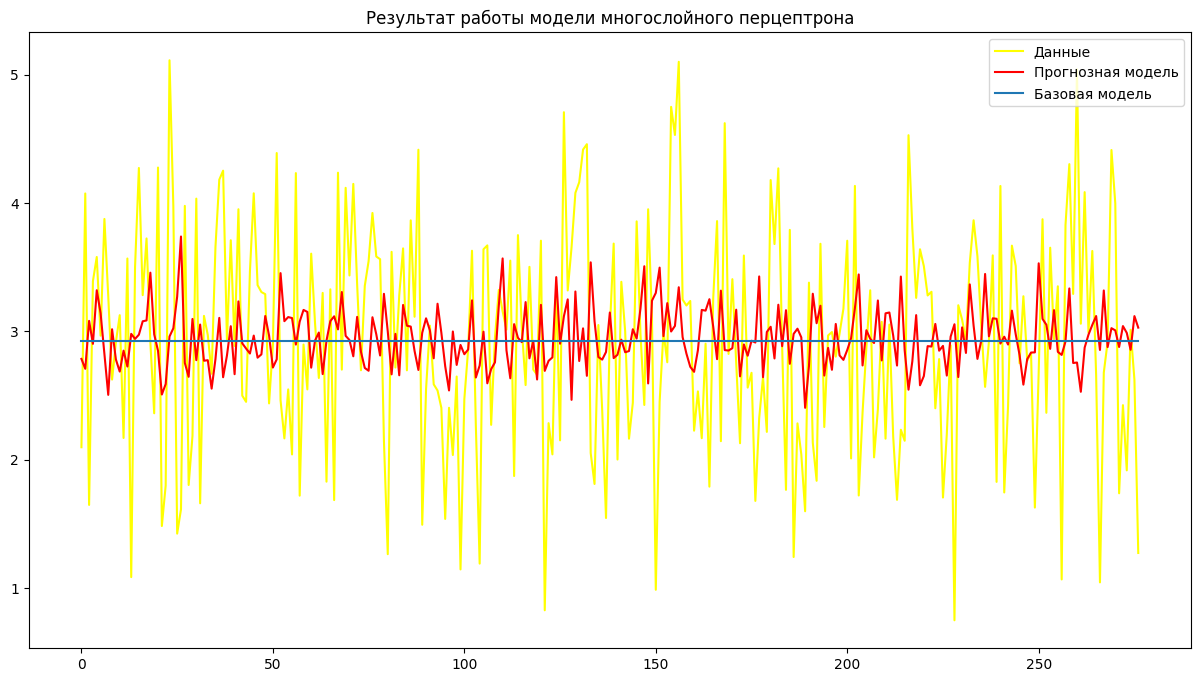

In [175]:
y3_pred_skl = mlp.predict(x3_test)

fig, ax = plt.subplots(figsize=(15, 8))
ax.plot(y3_test, color = 'yellow', label='Данные')
ax.plot(y3_pred_skl, color = 'red', label='Прогнозная модель')
ax.plot(y3_dummy, label='Базовая модель')
ax.legend()
plt.title('Результат работы модели многослойного перцептрона')
plt.show()

In [ ]:
diff_mlp = pd.DataFrame()

dummy_3 = calculate_metrics("Dummy Regressor", y3_test, y3_dummy)
diff_mlp = pd.concat([diff_mlp, dummy_3], ignore_index=False)

mlp_metrics = calculate_metrics("MLPRegressor", y3_test, y3_pred_skl)
diff_mlp = pd.concat([diff_mlp, mlp_metrics], ignore_index=False)

styled_diff_mlp = style_model_results(diff_mlp)
styled_diff_mlp

Нейронная сеть на TensorFlow

In [176]:
# создаем аналогичную архитектуру нейросети

def keras_model():
    return tf.keras.Sequential([
      keras.layers.Input(shape=(12,), name='in'),                      # 12 признаков
      keras.layers.Dense(64, activation='relu', name='dense_1'),
      keras.layers.Dense(64, activation='relu', name='dense_2'),
      keras.layers.Dense(32, activation='relu', name='dense_3'),
      keras.layers.Dense(32, activation='relu', name='dense_4'),
      keras.layers.Dense(16, activation='relu', name='dense_5'),
      keras.layers.Dense(16, activation='relu', name='dense_6'),
      keras.layers.Dense(8, activation='relu', name='dense_7'),
      keras.layers.Dense(8, activation='relu', name='dense_8'),
      keras.layers.Dense(1, name='out')
    ])

In [177]:
def compile_model(model):
    model.compile(
      optimizer=keras.optimizers.Adam(
            learning_rate=0.01,
      ),
      loss=keras.losses.MeanAbsolutePercentageError(),
      metrics=['mae', 'mape', 'root_mean_squared_error']
    )
    return model

In [178]:
# визуализация графиков ошибок

def plot_nn_loss(history):

    fig, axes = plt.subplots(1, 3, figsize=(18, 5))  # 3 графика в 1 ряду

    # MAPE
    axes[0].plot(history.history['loss'], label='train_loss (MAPE)', color='blue')
    axes[0].plot(history.history['val_loss'], label='val_loss (MAPE)', color='orange')
    axes[0].set_xlabel('Эпоха')
    axes[0].legend()
    axes[0].set_title('График MAPE')
    axes[0].grid(True)

    # RMSE
    axes[1].plot(history.history['root_mean_squared_error'], label='train_loss (RMSE)', color='blue')
    axes[1].plot(history.history['val_root_mean_squared_error'], label='val_loss (RMSE)', color='orange')
    axes[1].set_xlabel('Эпоха')
    axes[1].legend()
    axes[1].set_title('График RMSE')
    axes[1].grid(True)

    # MAE
    axes[2].plot(history.history['mae'], label='train_loss (MAE)', color='blue')
    axes[2].plot(history.history['val_mae'], label='val_loss (MAE)', color='orange')
    axes[2].set_xlabel('Эпоха')
    axes[2].legend()
    axes[2].set_title('График MAE')
    axes[2].grid(True)

    plt.show()

In [179]:
model_NN = keras_model()

model_NN = compile_model(model_NN) # компиляция нейросети

model_NN.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_1 (Dense)                      │ (None, 64)                  │             832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 16)                  │             272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 8)                   │             136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 8)                   │              72 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ out (Dense)                          │ (None, 1)                   │               9 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,145 (35.72 KB)

 Trainable params: 9,145 (35.72 KB)

 Non-trainable params: 0 (0.00 B)

In [180]:
model_NN_hist = model_NN.fit(
    x3_train,
    y3_train,
    epochs = 100,
    validation_split = 0.3,
    verbose = 1)

Epoch 1/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 95.5636 - mae: 2.8360 - mape: 95.5636 - root_mean_squared_error: 2.9803 - val_loss: 33.4639 - val_mae: 0.8572 - val_mape: 33.4639 - val_root_mean_squared_error: 1.0883
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 36.2331 - mae: 0.9636 - mape: 36.2331 - root_mean_squared_error: 1.1910 - val_loss: 36.9022 - val_mae: 0.8009 - val_mape: 36.9022 - val_root_mean_squared_error: 1.0186
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 28.3675 - mae: 0.8305 - mape: 28.3675 - root_mean_squared_error: 1.0461 - val_loss: 36.2600 - val_mae: 0.8004 - val_mape: 36.2600 - val_root_mean_squared_error: 1.0236
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 28.9705 - mae: 0.7895 - mape: 28.9705 - root_mean_squared_error: 0.9823 - val_loss: 33.2460 - val_mae: 0.7851 - val_mape: 33.2460 - val_root_mean_squared_error: 1.0064
Epoch 5/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 26.7624 - mae: 0.7577 - mape: 26

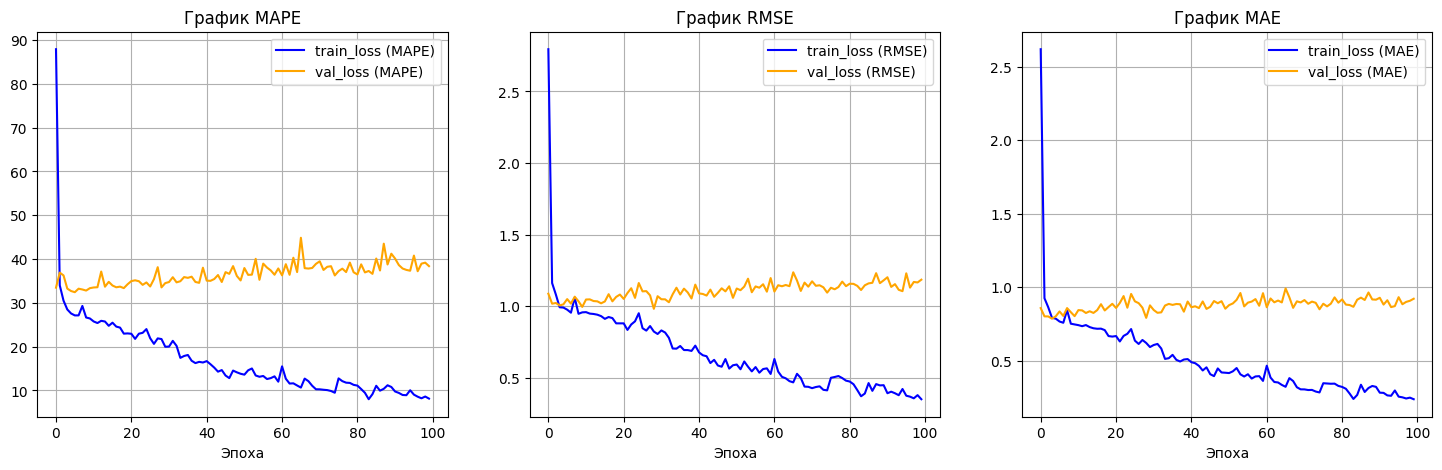

In [181]:
plot_nn_loss(model_NN_hist)

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


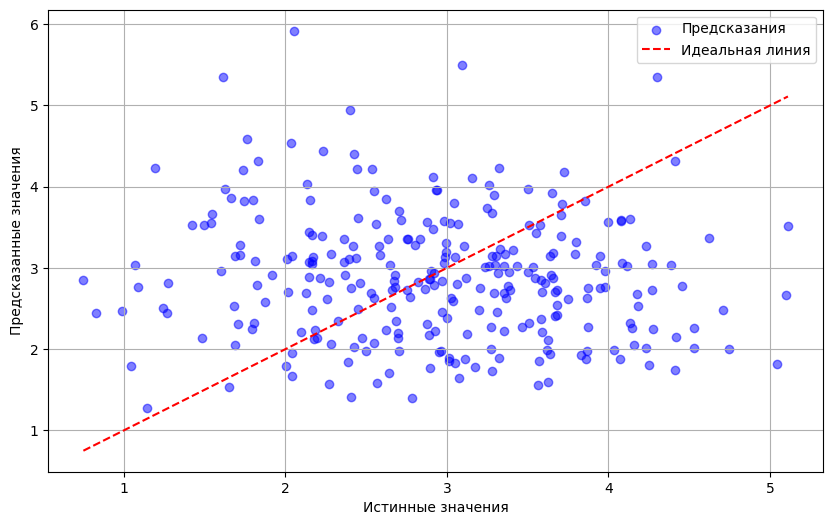

In [182]:
y3_NN_pred = model_NN.predict(x3_test)

plt.figure(figsize=(10, 6))
plt.scatter(y3_test, y3_NN_pred, alpha=0.5, color="blue", label="Предсказания")
plt.plot([min(y3_test), max(y3_test)], [min(y3_test), max(y3_test)], color="red", linestyle="--", label="Идеальная линия")
plt.xlabel("Истинные значения")
plt.ylabel("Предсказанные значения")
plt.legend()
plt.grid(True)
plt.show()

Постараюсь улучшить модель посредством добавления колбэка, дропаута, корректировки параметра коэффициента обучения и пакетной нормализации - нормализации входных данных слоев нейронки

In [183]:
from keras.layers import BatchNormalization
from keras.callbacks import EarlyStopping

def keras_model_2():
    return keras.Sequential([
        keras.layers.Input(shape=(12,), name='in'),

        keras.layers.Dense(64, name='dense_1'),
        keras.layers.BatchNormalization(),
        keras.layers.Activation('relu'),
        keras.layers.Dropout(0.05, name='dropout_1'),

        keras.layers.Dense(32, name='dense_2'),
        keras.layers.BatchNormalization(),
        keras.layers.Activation('relu'),
        keras.layers.Dropout(0.05, name='dropout_2'),

        keras.layers.Dense(16, name='dense_3'),
        keras.layers.BatchNormalization(),
        keras.layers.Activation('relu'),
        keras.layers.Dropout(0.05, name='dropout_3'),

        keras.layers.Dense(8, name='dense_4'),
        keras.layers.BatchNormalization(),
        keras.layers.Activation('relu'),
        keras.layers.Dropout(0.05, name='dropout_4'),

        keras.layers.Dense(1, name='out')
    ])

In [184]:
def compile_model_2(model):
    model.compile(
      optimizer=keras.optimizers.Adam(
            learning_rate=0.001,
      ),
      loss=keras.losses.MeanAbsolutePercentageError(),
      metrics=['mae', 'mape', 'root_mean_squared_error']
    )
    return model

In [185]:
# добавим колбэк, который остановит обучение, если ошибка на валидации перестанет снижаться

early_stopping = EarlyStopping(
    monitor='val_loss',  # отслеживаемая метрика
    patience=20,         # количество эпох без улучшений
    restore_best_weights=True
)

In [186]:
model_NN_2 = keras_model_2()

model_NN_2 = compile_model_2(model_NN_2) # компиляция нейросети

model_NN_2.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_1 (Dense)                      │ (None, 64)                  │             832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_4 (Activation)            │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_5 (Activation)            │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 16)                  │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_6 (Activation)            │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 8)                   │             136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 8)                   │              32 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_7 (Activation)            │ (None, 8)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 8)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ out (Dense)                          │ (None, 1)                   │               9 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,065 (15.88 KB)

 Trainable params: 3,825 (14.94 KB)

 Non-trainable params: 240 (960.00 B)

In [187]:
model_NN_hist_2 = model_NN_2.fit(
    x3_train, y3_train,
    epochs=1000,
    validation_split = 0.3,
    verbose=1,
    callbacks=[early_stopping]
)

Epoch 1/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 88.1774 - mae: 2.6336 - mape: 88.1774 - root_mean_squared_error: 2.9034 - val_loss: 101.3080 - val_mae: 2.9400 - val_mape: 101.3080 - val_root_mean_squared_error: 3.0803
Epoch 2/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 85.1272 - mae: 2.5797 - mape: 85.1272 - root_mean_squared_error: 2.8376 - val_loss: 97.3045 - val_mae: 2.8419 - val_mape: 97.3045 - val_root_mean_squared_error: 2.9895
Epoch 3/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 82.6406 - mae: 2.4761 - mape: 82.6406 - root_mean_squared_error: 2.7456 - val_loss: 92.0091 - val_mae: 2.7142 - val_mape: 92.0091 - val_root_mean_squared_error: 2.8732
Epoch 4/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 76.4391 - mae: 2.3288 - mape: 76.4391 - root_mean_squared_error: 2.6428 - val_loss: 85.7786 - val_mae: 2.5604 - val_mape: 85.7786 - val_root_mean_squared_error: 2.7348
Epoch 5/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 72.8013 - mae: 2.2118 - 

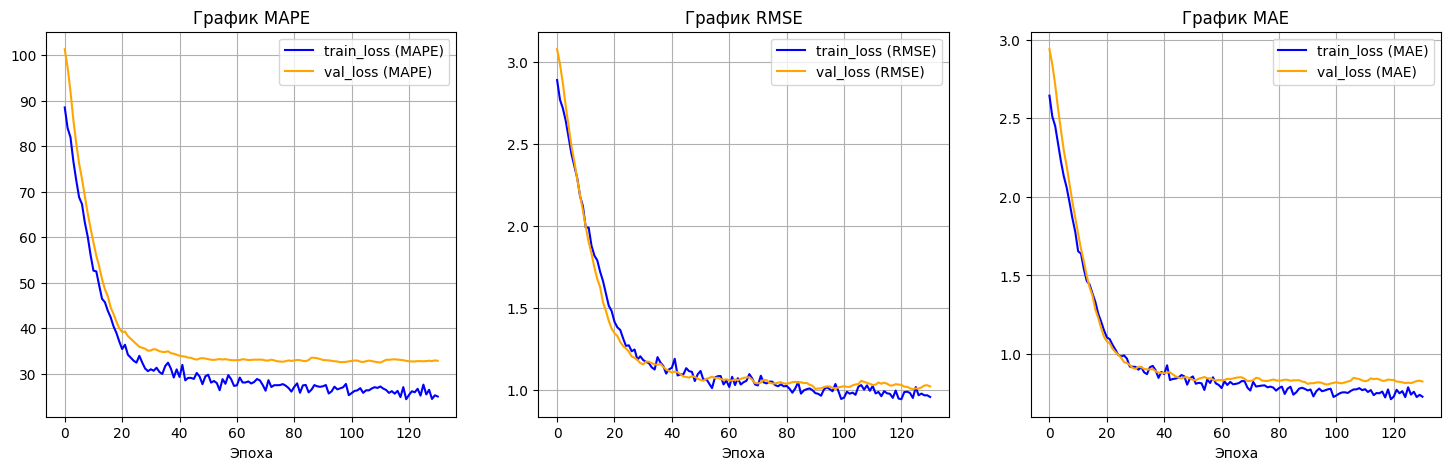

In [188]:
plot_nn_loss(model_NN_hist_2)

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


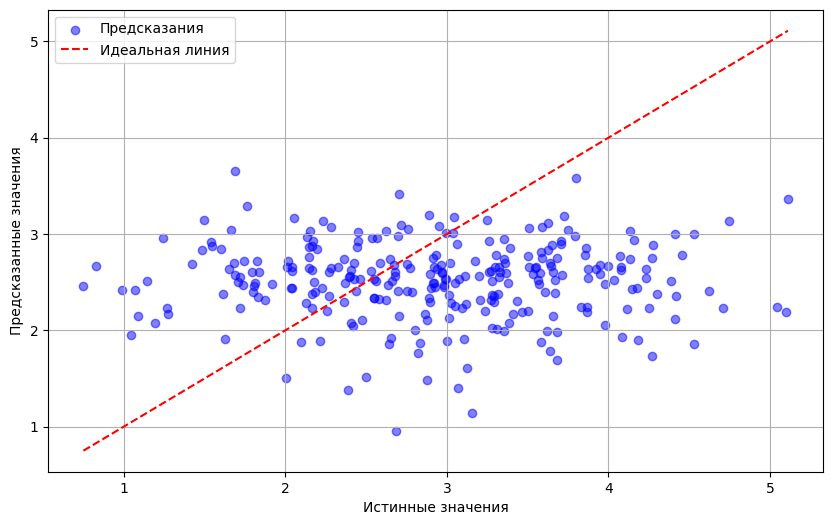

In [189]:
y3_NN_pred_2 = model_NN_2.predict(x3_test)

plt.figure(figsize=(10, 6))
plt.scatter(y3_test, y3_NN_pred_2, alpha=0.5, color="blue", label="Предсказания")
plt.plot([min(y3_test), max(y3_test)], [min(y3_test), max(y3_test)], color="red", linestyle="--", label="Идеальная линия")
plt.xlabel("Истинные значения")
plt.ylabel("Предсказанные значения")
plt.legend()
plt.grid(True)
plt.show()

In [190]:
models_diff = calculate_metrics('Dummy Regressor', y3_test, y3_dummy)

models_diff = pd.concat([
    models_diff,
    calculate_metrics('Обученная нейросеть', y3_test, y3_NN_pred),
    calculate_metrics('Нейросеть модифицированная', y3_test, y3_NN_pred_2)
],
    ignore_index=False)

styled_models_diff = style_model_results(models_diff)
styled_models_diff

,R2,RMSE,MAE,MAPE
Dummy Regressor,-0.000080,0.874368,0.710610,0.303820
Обученная нейросеть,-0.976090,1.229081,0.977477,0.393238
Нейросеть модифицированная,-0.438251,1.048563,0.867306,0.320932


Нейронные сети показали себя хуже базовой модели.
Обычная нейросеть продемонстрировала высокий уровень ошибки и слабую обобщающую способность.
Модифицированная нейросеть несколько снизила ошибки, но по коэффициенту детерминации также показала неудовлетворительный результат. В целом, ни одна из моделей не смогла превзойти базовую по коэффициенту детерминации, что говорит о необходимости доработки архитектуры или предобработки данных.

In [191]:
all_best_results = pd.DataFrame()

all_best_results_1 = pd.DataFrame()
y1_predicted_train = best_model_1.predict(x1_train)
all_best_results_1 = pd.concat([all_best_results_1, calculate_metrics('Train по параметру Модуль упругости при растяжении', y1_train, y1_predicted_train)], ignore_index=False)
y1_predicted_test = best_model_1.predict(x1_test)
all_best_results_1 = pd.concat([all_best_results_1, calculate_metrics('Test по параметру Модуль упругости при растяжении', y1_test, y1_predicted_test)], ignore_index=False)
all_best_results_1 = all_best_results_1.round(3)

all_best_results_2 = pd.DataFrame()
y2_predicted_train = best_model_2.predict(x2_train)
all_best_results_2 = pd.concat([all_best_results_2, calculate_metrics('Train по параметру Прочность при растяжении', y2_train, y2_predicted_train)], ignore_index=False)
y2_predicted_test = best_model_2.predict(x2_test)
all_best_results_2 = pd.concat([all_best_results_2, calculate_metrics('Test по параметру Прочность при растяжении', y2_test, y2_predicted_test)], ignore_index=False)

all_best_results_3 = pd.DataFrame()
y3_predicted_train = model_NN_2.predict(x3_train)
all_best_results_3 = pd.concat([all_best_results_3, calculate_metrics('Train по параметру Соотношение матрица-наполнитель', y3_train, y3_predicted_train)], ignore_index=False)
y3_predicted_test = model_NN_2.predict(x3_test)
all_best_results_3 = pd.concat([all_best_results_3, calculate_metrics('Test по параметру Соотношение матрица-наполнитель', y3_test, y3_predicted_test)], ignore_index=False)

all_best_results = pd.concat([all_best_results_1, all_best_results_2, all_best_results_3], ignore_index=False)
all_best_results

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


,R2,RMSE,MAE,MAPE
Train по параметру Модуль упругости при растяжении,0.0,2.964995,2.388992,0.032669
Test по параметру Модуль упругости при растяжении,-0.008879,3.162017,2.580193,0.035032
Train по параметру Прочность при растяжении,0.039483,440.289051,351.024149,0.151906
Test по параметру Прочность при растяжении,-0.001992,463.112002,369.709111,0.162112
Train по параметру Соотношение матрица-наполнитель,-0.001998,0.904603,0.689468,0.243023
Test по параметру Соотношение матрица-наполнитель,-0.438251,1.048563,0.867306,0.320932


Линейная модель Lasso показала отрицательное значение R² на тестовом датасете,  что говорит о том, что модель работает хуже, чем простое среднее значение.

Хотя бы градиентный бустинг показал положительный R² на тренировочном датасете, то есть модель смогла уловить часть зависимости. На тестовом датасете из-за возможного переобучения коэф детерминации чуть ниже нуля. Значения RMSE, MAE и MAPE остаются аналогично высокими.

Нейросеть показала наихудший результат среди моделей: отрицательные значения R² как на тренировочном, так и на тестовом датасете. Настроенная мною нейросеть не смогла уловить зависимость в данных и, возможно, просто запомнила шум. Ошибки также остаются высокими.

In [192]:
# дополнительно найду максимальные значения ошибок, чтобы оценить насколько релевантны лучшие модели

def calculate_max_error(model_name, true_values, predicted_values):

    results = pd.DataFrame(index=[model_name])
    results.loc[model_name, 'max_error'] = metrics.max_error(true_values, predicted_values)

    return results

In [193]:
all_max_errors = pd.DataFrame()

max_error_1 = pd.DataFrame()
y1_predicted_test_error = best_model_1.predict(x1_test)
max_error_1 = pd.concat([max_error_1, calculate_max_error('Test по параметру Модуль упругости при растяжении', y1_test, y1_predicted_test_error)], ignore_index=False)

max_error_2 = pd.DataFrame()
y2_predicted_test_error = best_model_2.predict(x2_test)
max_error_2 = pd.concat([max_error_2, calculate_max_error('Test по параметру Прочность при растяжении', y2_test, y2_predicted_test_error)], ignore_index=False)

max_error_3 = pd.DataFrame()
y3_predicted_test = model_NN_2.predict(x3_test)
max_error_3 = pd.concat([max_error_3, calculate_max_error('Test по параметру Соотношение матрица-наполнитель', y3_test, y3_predicted_test)], ignore_index=False)

all_max_errors = pd.concat([max_error_1, max_error_2, max_error_3], ignore_index=False)
all_max_errors

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


,max_error
Test по параметру Модуль упругости при растяжении,7.960885
Test по параметру Прочность при растяжении,1231.471332
Test по параметру Соотношение матрица-наполнитель,2.907571


# Приложение с графическим интерфейсом, выдающее прогноз на основании созданных моделей

В качестве модели для прогнозирования буду использовать нейронную сеть на tensorflow.

In [194]:
from flask import Flask, request, render_template
import numpy as np
import tensorflow as tf
from tensorflow import keras
import os
import pickle

In [195]:
# cоздаём папку models
os.makedirs("models", exist_ok=True)

In [199]:
model_path = "model_NN_2.keras"
model_NN_2.save(model_path)

In [197]:
x3_train_df = pd.DataFrame(x3_train, columns=['var2', 'var3', 'var4', 'var5', 'var6', 'var7', 'var8', 'var9', 'var10', 'var11', 'var12', 'var13'])

# Создание и обучение препроцессора
preprocessor = ColumnTransformer([
    ('scaler', StandardScaler(), ['var2', 'var3', 'var4', 'var5', 'var6', 'var7', 'var8', 'var9', 'var10', 'var11', 'var12', 'var13'])
])

# Обучение препроцессора на тренировочных данных
preprocessor.fit(x3_train_df)

# Сохранение препроцессора
with open('models/Preprocessor_NN_scaler.pkl', 'wb') as f:
    pickle.dump(preprocessor, f)